# 3주차 Multilayer perceptron

<img src='https://d2l.ai/_images/mlp.svg'>




## 3.1 Activation function

In [1]:
!pip install --quiet d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have num

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

### a. ReLU

현재까지 널리 사용되면서, 적용하기 쉬운 비선형 활성화 함수 *rectified linear unit* **(ReLU)** 함수를 그려봅시다.


$$ \texttt{ReLU}(x)=\max\{x, 0\} $$



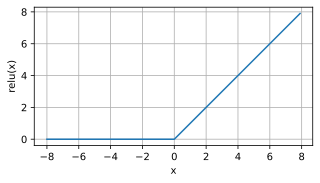

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))


ReLU 함수의 미분꼴은 *heavyside function* 입니다.

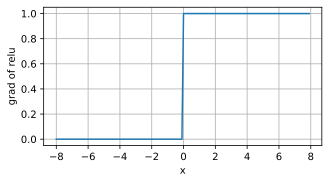

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

* ReLU 함수를 직접 구현해봅시다!

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = ## 빈칸을 채워주세요

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()

y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### b. Sigmoid

Sigmoid 함수는 실수 전체 $\mathbb{R}$ 도메인을 $(0, 1)$ 구간으로 맵핑하는 함수입니다.

$$ \texttt{Sigmoid}(x)={1\over 1+\exp(-x)}  $$


기울기 기반 학습 과정에서 sigmoid 는 부드럽고 미분가능한 좋은 성질을 가진 함수입니다.

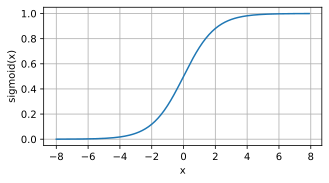

In [5]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

한편 sigmoid 함수의 미분은 다시 자기자신을 이용한 형태로 나타납니다.

$$ {d\over dx}\texttt{sigmoid}(x)={\exp(-x)\over(1+\exp(-x))^2}=\texttt{sigmoid}(x)(1-\texttt{sigmoid}(x)). $$

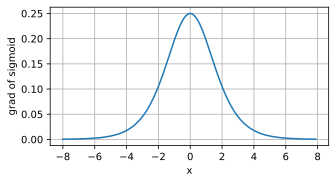

In [6]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

* Sigmoid 함수를 직접 구현해봅시다!

In [ ]:
y = ## 빈칸을 채워주세요 ##

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## 3.2 MLP implementation



In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer ##, load_digits, load_wine ##

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1. Load dataset

In [2]:
data = load_breast_cancer()

In [3]:
input = data.data
output = data.target

* GPU 사용이 가능하다면 device 를 GPU 로 설정!

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

* 데이터를 미리 설정한 device 로 이동합니다.

In [15]:
## Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [16]:
print(x_train[0])
print(y_train[0])

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02],
       device='cuda:0')
tensor(1, device='cuda:0')


## Step 2 : CustomDataset 과 DataLoader

In [19]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [20]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

## Step 3 : Define "Model"

* activation function 이용

  * nn.Sigmoid()
  * nn.ReLU()
  * nn.tanH()


* batch normazliation 1d 란?
  * 파라미터 값으로 vector의 길이를 전해줌



* a. 직접 nn.Sequential() 로 구현하기

In [21]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

* b. 파이썬 Class 로 구현하기

In [22]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398, 15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, y_len, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

* Weight initialization

In [23]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [26]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-23-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


## Step 4 : Loss function 과 Optimizer

* 다양한 optimizer 가 존재
  * https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [27]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [28]:
optimizer = optim.Adam(model.parameters(), lr= 0.01)

## Step 5: Train Model

In [29]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.741421103477478
10 0.5063179135322571
20 0.42135950922966003
30 0.3962841033935547
40 0.38843148946762085
50 0.3830665349960327
60 0.40513870120048523
70 0.3734109699726105
80 0.3830457031726837
90 0.36680924892425537


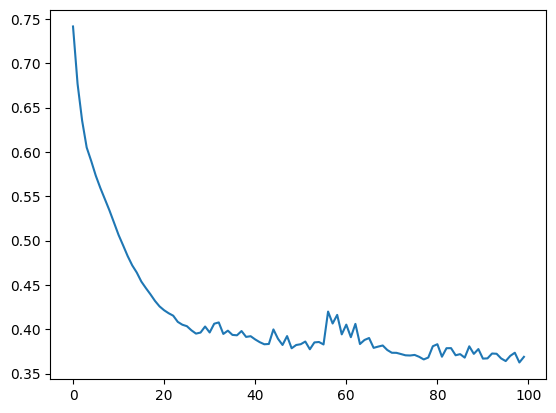

In [30]:
plt.plot(losses)
plt.show()

In [31]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [32]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.01012038 0.9898796 ]
argmax를 한 후의 output은 1
accuracy는 0.9064327485380117


# MLP 를 다뤄봅시다!

위 코드를 참고하여 직접 MLP 를 구현해봅시다.

load_digits() 또는 load_wine() 중 하나를 골라 시도해보세요!

- lr, optimizer, hidden layer(depth), neuron 수(width)를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!

In [ ]:
from sklearn.datasets import ## load_digits, load_wine